In [1]:
import osmnx as ox
import numpy as np
import collections
import networkx as nx
from tqdm import tqdm
import time

In [2]:
help(ox.graph_from_bbox)

Help on function graph_from_bbox in module osmnx.graph:

graph_from_bbox(north, south, east, west, network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    Create a graph from OSM within some bounding box.
    
    Parameters
    ----------
    north : float
        northern latitude of bounding box
    south : float
        southern latitude of bounding box
    east : float
        eastern longitude of bounding box
    west : float
        western longitude of bounding box
    network_type : string {"all_private", "all", "bike", "drive", "drive_service", "walk"}
        what type of street network to get if custom_filter is None
    simplify : bool
        if True, simplify graph topology with the `simplify_graph` function
    retain_all : bool
        if True, return the entire graph even if it is not connected.
        otherwise, retain only the largest weakly connected component.
    truncate_by_edge : bool
 

# Step 0: initialize graph and describe the raw graph 

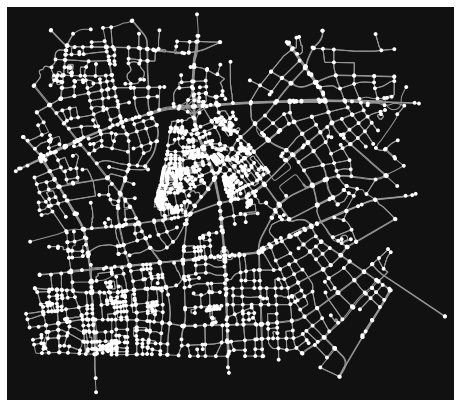

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
north = 30.3190
south = 30.2608
east = 120.1552
west = 120.2305
G = ox.graph_from_bbox(north, south, east, west, network_type='drive', truncate_by_edge=True)
ox.plot_graph(G)

In [4]:
def describe_graph(G):
    print('describe graph')
    count = 0
    d3_count = 0
    node_types = []
    for nd, d in G.degree():
        try:
            if G.nodes[nd]['street_count'] != d:
                count += 1
        except: 
            count +=1 
        if d >= 3:
            d3_count += 1
        if 'highway' in G.nodes[nd].keys(): #and G.nodes[nd]['highway'] == 'traffic signal':
            node_types.append(G.nodes[nd]['highway'])
    print("{} nodes in total".format(count))
    print("{} nodes with degree >= 3".format(d3_count))
    node_count = collections.Counter(node_types)
    print("Node types description and counting: ")
    
    return node_count
describe_graph(G)

describe graph
1760 nodes in total
1989 nodes with degree >= 3
Node types description and counting: 


Counter({'traffic_signals': 112,
         'crossing': 3,
         'motorway_junction': 1,
         'turning_circle': 1})

In [5]:
Gc = ox.consolidate_intersections(G, tolerance=10)
describe_graph(Gc)

/home/kan/.local/lib/python3.8/site-packages/osmnx/simplification.py:417: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = utils_graph.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
/home/kan/.local/lib/python3.8/site-packages/osmnx/simplification.py:466: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = node_clusters.centroid


describe graph
1 nodes in total
1 nodes with degree >= 3
Node types description and counting: 


Counter()

In [6]:
G0 = nx.Graph(G)
edge_list = list(G0.edges())
print(len(edge_list))
demo_edge = edge_list[100]

3416


In [7]:
G0.edges[demo_edge]

{'osmid': 4337671,
 'oneway': True,
 'lanes': '2',
 'name': '东新路',
 'highway': 'primary',
 'length': 22.417}

In [8]:
nodes_list = list(G0.nodes())
print(len(nodes_list))
print(nodes_list[0])
demo_node = nodes_list[0]

2290
25926073


In [9]:
# G0.edges() #(26683058, 32757160)

In [10]:
G0[25926073][27127987]

{'osmid': 4296592,
 'lanes': '1',
 'name': '朝晖路',
 'highway': 'tertiary',
 'oneway': False,
 'length': 24.239}

In [11]:
G0[26683058][32757160]

{'osmid': 331692230,
 'oneway': True,
 'highway': 'tertiary_link',
 'length': 107.851,
 'geometry': <shapely.geometry.linestring.LineString at 0x7fc8c587e4c0>}

In [12]:
G0[32757160][26683058]

{'osmid': 331692230,
 'oneway': True,
 'highway': 'tertiary_link',
 'length': 107.851,
 'geometry': <shapely.geometry.linestring.LineString at 0x7fc8c587e4c0>}

In [13]:
G0[26334772][5057734479]

{'osmid': 4317655,
 'oneway': True,
 'lanes': '2',
 'name': '绍兴路',
 'highway': 'primary',
 'length': 149.519}

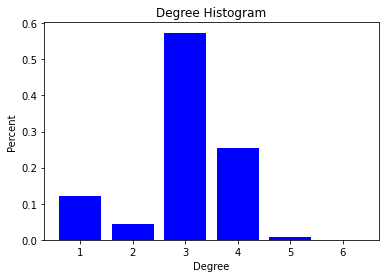

maximum edge length: 2179 meters


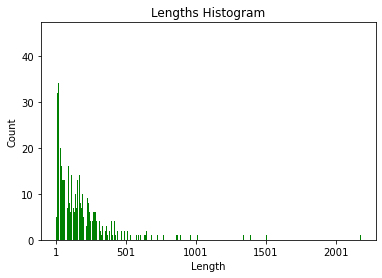

In [14]:
# helper functions
import collections
import matplotlib.pyplot as plt
import numpy as np

def plot_length_histogram(G):
    '''
    hist1: edge length distribution
    hist2: node degree distribution
    '''
    lengths_sequence = sorted([int(G.edges[e]['length']) for e in G.edges()])
    length_count = collections.Counter(lengths_sequence)
    length, cnt = zip(*length_count.items())
    percent = [ct/sum(cnt) for ct in cnt]
    
    fig, ax = plt.subplots()
    plt.bar(length, cnt, width=0.80, color="g")
    
    plt.title("Lengths Histogram")
    plt.ylabel("Count")
    plt.xlabel("Length")
    ax.set_xticks([l for l in range(min(length), max(length)+1, 500)])
#     ax.set_xticklabels(length)
    print("maximum edge length: {} meters".format(max(length)))
    plt.show()
    

def plot_degree_histogram(G):
    degree_sequence = sorted([d for n, d in G.degree()])  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    
    count5 = sum(np.array(degree_sequence) > 4)
#     print("{} nodes with degree >= 5".format(count5))
    percent = [ct/sum(cnt) for ct in cnt]
    
    fig, ax = plt.subplots()
    plt.bar(deg, percent, width=0.80, color="b")

    plt.title("Degree Histogram")
    plt.ylabel("Percent")
    plt.xlabel("Degree")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg)
    plt.show()
    
plot_degree_histogram(G0)
plot_length_histogram(G0)

In [15]:
def describe_degree(G):
    degree_sequence = sorted([d for n, d in G.degree()])  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    total_cnt = sum(cnt)
    
    degreePercent = dict()
    for key, val in degreeCount.items():
        degreePercent[key] = val / total_cnt
    
    return degreePercent, degreeCount

In [16]:
degreePercent, degreeCount = describe_degree(G0)
print("node degree counts: ")
print(degreeCount)

print("node degree distribution: ")
degreePercent

node degree counts: 
Counter({3: 1314, 4: 582, 1: 278, 2: 99, 5: 16, 6: 1})
node degree distribution: 


{1: 0.12139737991266375,
 2: 0.04323144104803493,
 3: 0.5737991266375546,
 4: 0.2541484716157205,
 5: 0.0069868995633187774,
 6: 0.0004366812227074236}

In [17]:
def compute_network_length(G):
    network_length = 0
    for e in G.edges():
        network_length += G[e[0]][e[1]]['length']
    return network_length
print(compute_network_length(G0))

596212.5300000015


In [18]:
import pandas as pd
def get_node_df(G):
    '''
    return node_df
        - node_id
        - x_coord
        - y_coord
        - osm_highway
    '''
    cols = ['node_id', 'osm_node_id','x_coord', 'y_coord', 'osm_highway', 'ctrl_type']
    x_coords = list()
    y_coords = list()
    osm_ids = list()
    osm_highway = list()
    rows = list()
    node_osm = dict()
    
    cnt = 0
    for nd in G.nodes():
        node_osm[nd] = cnt
        node = G.nodes[nd]
        try:
            osm_highway = node['highway']
            ctrl_type = 'signal'
        except:
            osm_highway = 'normal'
            ctrl_type = None
        
        row = [cnt, nd, node['x'], node['y'], osm_highway, ctrl_type]
        cnt += 1
        rows.append(row)
    
    node_df = pd.DataFrame(rows, columns=cols)
    
    return node_df, node_osm
node_df, node_osm = get_node_df(G)
node_df

,node_id,osm_node_id,x_coord,y_coord,osm_highway,ctrl_type
0,0,25926073,120.165330,30.279548,traffic_signals,signal
1,1,25926083,120.171881,30.280814,normal,None
2,2,25926085,120.172449,30.280852,normal,None
3,3,25926086,120.173096,30.280994,traffic_signals,signal
4,4,25926100,120.178018,30.282351,traffic_signals,signal
...,...,...,...,...,...,...
2285,2285,9513192809,120.232920,30.292137,normal,None
2286,2286,9612382671,120.228289,30.272129,normal,None
2287,2287,9612382672,120.227409,30.272948,normal,None
2288,2288,9612382677,120.231262,30.272420,normal,None


In [19]:
m = node_df['osm_highway'] == 'traffic_signals'
node_df[m]

,node_id,osm_node_id,x_coord,y_coord,osm_highway,ctrl_type
0,0,25926073,120.165330,30.279548,traffic_signals,signal
3,3,25926086,120.173096,30.280994,traffic_signals,signal
4,4,25926100,120.178018,30.282351,traffic_signals,signal
5,5,25954988,120.161267,30.278626,traffic_signals,signal
7,7,26041224,120.172358,30.290904,traffic_signals,signal
...,...,...,...,...,...,...
1391,1391,5577936116,120.181051,30.277592,traffic_signals,signal
1394,1394,5577937036,120.183182,30.266282,traffic_signals,signal
1395,1395,5577937037,120.183171,30.266203,traffic_signals,signal
1747,1747,7590858480,120.203073,30.269766,traffic_signals,signal


In [20]:
t = "4;2"
x = t.split(';')
x

['4', '2']

In [21]:
speed_map = {
    'corridor': 50/3.6,
    'living_street': 20/3.6,
    'motorway': 80/3.6,
    'motorway_link': 60/3.6,
    'primary': 60/3.6,
    'primary_link': 60/3.6,
    'residential': 30/3.6,
    'road': 40/3.6,
    'secondary': 50/3.6,
    'secondary_link': 50/3.6,
    'service': 30/3.6,
    'tertiary': 40/3.6,
    'tertiary_link': 40/3.6,
    'track': 20/3.6,
    'trunk': 60/3.6,
    'trunk_link': 60/3.6,
    'unclassified': 35/3.6
}

DEFAULT_SPEED = 35/3.6

# {'osmid': 4317655,
#  'oneway': True,
#  'lanes': '2',
#  'name': '绍兴路',
#  'highway': 'primary',
#  'length': 149.519}

lane_map = {
    'corridor': 3,
    'living_street': 1,
    'motorway': 3,
    'motorway_link': 2,
    'primary': 3,
    'primary_link': 3,
    'residential': 1,
    'road': 2,
    'secondary': 3,
    'secondary_link': 3,
    'service': 1,
    'tertiary': 3,
    'tertiary_link': 3,
    'track': 1,
    'trunk': 3,
    'trunk_link': 3,
    'unclassified': 1
}

# models are as simple as possible, as complicated as necessary

from shapely.geometry import LineString


def get_edge_df(G, node_osm, drop_selfLoop=True):
    cols = ['link_id', 'link_osm_id', 'name', 'from_node_id', 'to_node_id', 'length', 'lanes', \
            'free_speed', 'link_type_name', 'from_node_osm', 'to_node_osm', 'geometry', 'allowed_uses']
    rows = list()
    guess_lanes = list()
    cnt = 0
    for eid in G.edges():
        from_nd, to_nd = eid[0], eid[1]
        if drop_selfLoop and (eid[0] == eid[1]): # drop self loops
            print(cnt)
#             cnt += 1
            continue
        
        from_nd_id, to_nd_id = node_osm[from_nd], node_osm[to_nd]
        e = G[from_nd][to_nd]
        
        if len(e) > 1:
            e = e[1]
        else:
            e = e[0]
        
        link_highway = e['highway']
        link_type = link_highway if type(link_highway) == str else link_highway[0]
        
        
        try:
            link_speed = int(e['maxspeed'])
        except:
            link_speed = speed_map[link_type]
#             link_speed = DEFAULT_SPEED
            
        try:
            name = e['name']
        except:
            name = None
        
        try:
            lanes = e['lanes']
            if len(lanes) > 1:
                if type(lanes) == str:
                    lanes = lanes.split(";")
                lanes = lanes[0]
                
            lanes = int(lanes)
            if lanes < 1:
                lanes = lane_map[link_type]
# #             print(e)
        except:
            lanes = lane_map[link_type]
            guess_lanes.append(e)
        
        try:
            geom = e['geometry']
        
        except:
            geom = LineString([(G.nodes[from_nd]['x'], G.nodes[from_nd]['y']), (G.nodes[to_nd]['x'], G.nodes[to_nd]['y'])])
        
        row = [cnt, e['osmid'], name, from_nd_id, to_nd_id, e['length'], lanes, link_speed, link_type, from_nd, to_nd, geom, 'auto']
        rows.append(row)
        cnt += 1
    print('number of edges with guessed lanes is {}'.format(len(guess_lanes)))
    
    return pd.DataFrame(rows, columns=cols)
link_df = get_edge_df(G, node_osm, drop_selfLoop=True)
link_df

2205
2205
2236
2236
3058
3058
3311
3311
4425
4425
4850
4850
number of edges with guessed lanes is 4773


,link_id,link_osm_id,name,from_node_id,to_node_id,length,lanes,free_speed,link_type_name,from_node_osm,to_node_osm,geometry,allowed_uses
0,0,4296592,朝晖路,0,104,24.239,1,11.111111,tertiary,25926073,27127987,"LINESTRING (120.1653304 30.2795476, 120.165554...",auto
1,1,4296592,朝晖路,0,755,120.788,1,11.111111,tertiary,25926073,4288712548,"LINESTRING (120.1653304 30.2795476, 120.165182...",auto
2,2,4296592,朝晖路,1,2,55.002,1,11.111111,tertiary,25926083,25926085,"LINESTRING (120.1718805 30.2808138, 120.172088...",auto
3,3,4296592,朝晖路,1,104,648.113,1,11.111111,tertiary,25926083,27127987,"LINESTRING (120.1718805 30.2808138, 120.171498...",auto
4,4,4380242,None,1,46,167.734,1,8.333333,residential,25926083,26447117,"LINESTRING (120.1718805 30.2808138, 120.171867...",auto
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5366,5366,572782831,之江东路,2288,1270,228.436,3,16.666667,primary,9612382677,5169099883,"LINESTRING (120.2312623 30.2724197, 120.231144...",auto
5367,5367,"[794232721, 532719558, 532719559]","[之江东路, 运河之江隧道]",2288,1269,1126.750,3,16.666667,primary,9612382677,5169099873,"LINESTRING (120.2312623 30.2724197, 120.230999...",auto
5368,5368,1044671634,None,2289,2287,1.090,3,11.111111,tertiary,9612382679,9612382672,"LINESTRING (120.2274168 30.2729412, 120.227409...",auto
5369,5369,1044671634,None,2289,2286,123.207,3,11.111111,tertiary,9612382679,9612382671,"LINESTRING (120.2274168 30.2729412, 120.228289...",auto


In [22]:
mmx = link_df['from_node_id'] == 992
link_df[mmx]

,link_id,link_osm_id,name,from_node_id,to_node_id,length,lanes,free_speed,link_type_name,from_node_osm,to_node_osm,geometry,allowed_uses
2205,2205,"[837013253, 837013254, 516169239]",None,992,991,131.915,1,8.333333,residential,5039244457,5039244442,"LINESTRING (120.1887606 30.2682094, 120.188891...",auto


In [23]:
node_csv = "./node_hz.csv"
link_csv = "./link_hz.csv"
node_df.to_csv(node_csv)
link_df.to_csv(link_csv)

In [24]:
# !pip install osm2gmns==0.6.4
import osm2gmns as og
net = og.loadNetFromCSV(node_file=node_csv, link_file=link_csv)
og.consolidateComplexIntersections(net, auto_identify=True, int_buffer=40)

osm2gmns, 0.6.4
Consolidating Complex Intersections


In [25]:
# og.buildMultiResolutionNets(net)
# og.outputNetToCSV(net, output_folder='./multi_resolution')

In [26]:
consolidate_folder = './consolidated'
og.outputNetToCSV(net, output_folder=consolidate_folder)
node_df1 = pd.read_csv(consolidate_folder + '/node.csv')
node_df1

Outputting Network Files


,name,node_id,osm_node_id,osm_highway,zone_id,ctrl_type,node_type,activity_type,is_boundary,x_coord,y_coord,intersection_id,poi_id,notes
0,NaN,1,25926083,normal,NaN,NaN,NaN,NaN,NaN,120.171881,30.280814,NaN,NaN,NaN
1,NaN,2,25926085,normal,NaN,NaN,NaN,NaN,NaN,120.172449,30.280852,NaN,NaN,NaN
2,NaN,5,25954988,traffic_signals,NaN,signal,NaN,NaN,NaN,120.161267,30.278626,NaN,NaN,NaN
3,NaN,6,25954989,normal,NaN,NaN,NaN,NaN,NaN,120.161990,30.278662,NaN,NaN,NaN
4,NaN,8,26041225,normal,NaN,NaN,NaN,NaN,NaN,120.171910,30.287966,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,NaN,2319,337362665_337362821_3357255995_3357255998,traffic_signals,NaN,signal,NaN,NaN,NaN,120.203906,30.292443,29.0,NaN,NaN
2226,NaN,2320,337362762_5178233282,traffic_signals,NaN,signal,NaN,NaN,NaN,120.207030,30.288775,33.0,NaN,NaN
2227,NaN,2321,3357256039_3357256040,traffic_signals,NaN,signal,NaN,NaN,NaN,120.207271,30.288445,30.0,NaN,NaN
2228,NaN,2322,3472105505_3472105507_5577937036_5577937037,traffic_signals,NaN,signal,NaN,NaN,NaN,120.183228,30.266235,32.0,NaN,NaN


In [27]:
link_df1 = pd.read_csv(consolidate_folder + '/link.csv')
link_df1

,name,link_id,osm_way_id,from_node_id,to_node_id,dir_flag,length,lanes,free_speed,capacity,link_type_name,link_type,geometry,allowed_uses,from_biway,is_link,VDF_fftt1,VDF_cap1
0,朝晖路,1,NaN,2290,755,1,120.78,1,11.111111,NaN,tertiary,0,"LINESTRING (120.1653304 30.2795476, 120.165182...",auto,0,0,NaN,NaN
1,朝晖路,2,NaN,1,2,1,55.08,1,11.111111,NaN,tertiary,0,"LINESTRING (120.1718805 30.2808138, 120.172088...",auto,0,0,NaN,NaN
2,朝晖路,3,NaN,1,2290,1,648.75,1,11.111111,NaN,tertiary,0,"LINESTRING (120.1718805 30.2808138, 120.171498...",auto,0,0,NaN,NaN
3,NaN,4,NaN,1,46,1,167.20,1,8.333333,NaN,residential,0,"LINESTRING (120.1718805 30.2808138, 120.171867...",auto,0,0,NaN,NaN
4,朝晖路,5,NaN,2,2291,1,64.11,1,11.111111,NaN,tertiary,0,"LINESTRING (120.1724491 30.2808524, 120.173095...",auto,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5281,之江东路,5366,NaN,2288,1270,1,227.96,3,16.666667,NaN,primary,0,"LINESTRING (120.2312623 30.2724197, 120.231144...",auto,0,0,NaN,NaN
5282,"['之江东路', '运河之江隧道']",5367,NaN,2288,1269,1,1124.36,3,16.666667,NaN,primary,0,"LINESTRING (120.2312623 30.2724197, 120.230999...",auto,0,0,NaN,NaN
5283,NaN,5368,NaN,2289,2287,1,1.09,3,11.111111,NaN,tertiary,0,"LINESTRING (120.2274168 30.2729412, 120.227409...",auto,0,0,NaN,NaN
5284,NaN,5369,NaN,2289,2286,1,123.07,3,11.111111,NaN,tertiary,0,"LINESTRING (120.2274168 30.2729412, 120.228289...",auto,0,0,NaN,NaN


In [28]:
# og.connectPOIWithNet(net)
# og.outputNetToCSV(net, output_folder=consolidate_folder)

In [29]:
DG0 = nx.from_pandas_edgelist(link_df1, source='from_node_id', target='to_node_id', edge_attr=True, create_using=nx.DiGraph)

# connect_type: 2way, enter, exit
def identify_bound_nodes(DG):
    tway_bounds = list()
    entry_bounds = list()
    exit_bounds = list()
    bound_type = dict()
    connect_type = dict() # primary, secondary, residential, etc..
    for nd in DG.nodes:
        # get predecssors & succesors
        preds = set(DG.predecessors(nd))
        succs = set(DG.successors(nd))

        if len(preds) <= 0:
            entry_bounds.append(nd)
            bound_type[nd] = 'entry'
            connect_type[nd] = DG[nd][list(succs)[0]]['link_type_name']
        elif len(succs) <= 0:
            exit_bounds.append(nd)
            bound_type[nd] = 'exit'
            connect_type[nd] = DG[list(preds)[0]][nd]['link_type_name']
        elif len(preds) == 1 and len(succs) == 1 and preds == succs:
            tway_bounds.append(nd)
            bound_type[nd] = '2way'
            connect_type[nd] = DG[list(preds)[0]][nd]['link_type_name']
        else:
            continue
    
    return tway_bounds, entry_bounds, exit_bounds, bound_type, connect_type
tway_bounds, entry_bounds, exit_bounds, bound_type, connect_type = identify_bound_nodes(DG0)

def update_node_df(node_df, bound_type, connect_type):
    for key, val in bound_type.items():
        node_df.loc[node_df['node_id'] == key, 'bound_type'] = val
        node_df.loc[node_df['node_id'] == key, 'connect_type'] = connect_type[key]
    
    return node_df
node_df2 = update_node_df(node_df1, bound_type, connect_type)
node_df2

,name,node_id,osm_node_id,osm_highway,zone_id,ctrl_type,node_type,activity_type,is_boundary,x_coord,y_coord,intersection_id,poi_id,notes,bound_type,connect_type
0,NaN,1,25926083,normal,NaN,NaN,NaN,NaN,NaN,120.171881,30.280814,NaN,NaN,NaN,NaN,NaN
1,NaN,2,25926085,normal,NaN,NaN,NaN,NaN,NaN,120.172449,30.280852,NaN,NaN,NaN,NaN,NaN
2,NaN,5,25954988,traffic_signals,NaN,signal,NaN,NaN,NaN,120.161267,30.278626,NaN,NaN,NaN,NaN,NaN
3,NaN,6,25954989,normal,NaN,NaN,NaN,NaN,NaN,120.161990,30.278662,NaN,NaN,NaN,NaN,NaN
4,NaN,8,26041225,normal,NaN,NaN,NaN,NaN,NaN,120.171910,30.287966,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,NaN,2319,337362665_337362821_3357255995_3357255998,traffic_signals,NaN,signal,NaN,NaN,NaN,120.203906,30.292443,29.0,NaN,NaN,NaN,NaN
2226,NaN,2320,337362762_5178233282,traffic_signals,NaN,signal,NaN,NaN,NaN,120.207030,30.288775,33.0,NaN,NaN,NaN,NaN
2227,NaN,2321,3357256039_3357256040,traffic_signals,NaN,signal,NaN,NaN,NaN,120.207271,30.288445,30.0,NaN,NaN,NaN,NaN
2228,NaN,2322,3472105505_3472105507_5577937036_5577937037,traffic_signals,NaN,signal,NaN,NaN,NaN,120.183228,30.266235,32.0,NaN,NaN,NaN,NaN


In [30]:
mm = node_df2['bound_type'] == '2way'
node_df2[mm]

,name,node_id,osm_node_id,osm_highway,zone_id,ctrl_type,node_type,activity_type,is_boundary,x_coord,y_coord,intersection_id,poi_id,notes,bound_type,connect_type
13,NaN,36,26364164,normal,NaN,NaN,NaN,NaN,NaN,120.157356,30.275437,NaN,NaN,NaN,2way,tertiary
21,NaN,52,26666462,normal,NaN,NaN,NaN,NaN,NaN,120.159592,30.275665,NaN,NaN,NaN,2way,tertiary
31,NaN,66,26685020,normal,NaN,NaN,NaN,NaN,NaN,120.198400,30.278993,NaN,NaN,NaN,2way,unclassified
58,NaN,96,27002371,normal,NaN,NaN,NaN,NaN,NaN,120.164229,30.295229,NaN,NaN,NaN,2way,unclassified
71,NaN,117,28583914,normal,NaN,NaN,NaN,NaN,NaN,120.174500,30.279081,NaN,NaN,NaN,2way,residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,NaN,2273,9136968587,normal,NaN,NaN,NaN,NaN,NaN,120.155269,30.264095,NaN,NaN,NaN,2way,unclassified
2180,NaN,2274,9136968590,normal,NaN,NaN,NaN,NaN,NaN,120.153424,30.263170,NaN,NaN,NaN,2way,unclassified
2186,NaN,2280,9452905766,normal,NaN,NaN,NaN,NaN,NaN,120.228711,30.302614,NaN,NaN,NaN,2way,unclassified
2187,NaN,2281,9452905773,normal,NaN,NaN,NaN,NaN,NaN,120.230253,30.306458,NaN,NaN,NaN,2way,tertiary


In [31]:
# convert to SUMO format
from SUMO_road import read_node_file, read_link_file

node_file_path = consolidate_folder + '/node.csv'
node_out_file_path = 'node_sumo.nod.xml'
read_node_file(node_file_path,node_out_file_path)
link_file_path = consolidate_folder + '/link.csv'
edge_out_file_path = 'edge_sumo.edg.xml'
read_link_file(link_file_path,edge_out_file_path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2230 entries, 0 to 2229
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             0 non-null      float64
 1   node_id          2230 non-null   int64  
 2   osm_node_id      2230 non-null   object 
 3   osm_highway      2230 non-null   object 
 4   zone_id          0 non-null      float64
 5   ctrl_type        57 non-null     object 
 6   node_type        0 non-null      float64
 7   activity_type    0 non-null      float64
 8   is_boundary      0 non-null      float64
 9   x_coord          2230 non-null   float64
 10  y_coord          2230 non-null   float64
 11  intersection_id  34 non-null     float64
 12  poi_id           0 non-null      float64
 13  notes            0 non-null      float64
dtypes: float64(10), int64(1), object(3)
memory usage: 244.0+ KB
None
0          1
1          2
2          5
3          6
4          8
        ... 
2225    2

In [32]:
link_df1

,name,link_id,osm_way_id,from_node_id,to_node_id,dir_flag,length,lanes,free_speed,capacity,link_type_name,link_type,geometry,allowed_uses,from_biway,is_link,VDF_fftt1,VDF_cap1
0,朝晖路,1,NaN,2290,755,1,120.78,1,11.111111,NaN,tertiary,0,"LINESTRING (120.1653304 30.2795476, 120.165182...",auto,0,0,NaN,NaN
1,朝晖路,2,NaN,1,2,1,55.08,1,11.111111,NaN,tertiary,0,"LINESTRING (120.1718805 30.2808138, 120.172088...",auto,0,0,NaN,NaN
2,朝晖路,3,NaN,1,2290,1,648.75,1,11.111111,NaN,tertiary,0,"LINESTRING (120.1718805 30.2808138, 120.171498...",auto,0,0,NaN,NaN
3,NaN,4,NaN,1,46,1,167.20,1,8.333333,NaN,residential,0,"LINESTRING (120.1718805 30.2808138, 120.171867...",auto,0,0,NaN,NaN
4,朝晖路,5,NaN,2,2291,1,64.11,1,11.111111,NaN,tertiary,0,"LINESTRING (120.1724491 30.2808524, 120.173095...",auto,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5281,之江东路,5366,NaN,2288,1270,1,227.96,3,16.666667,NaN,primary,0,"LINESTRING (120.2312623 30.2724197, 120.231144...",auto,0,0,NaN,NaN
5282,"['之江东路', '运河之江隧道']",5367,NaN,2288,1269,1,1124.36,3,16.666667,NaN,primary,0,"LINESTRING (120.2312623 30.2724197, 120.230999...",auto,0,0,NaN,NaN
5283,NaN,5368,NaN,2289,2287,1,1.09,3,11.111111,NaN,tertiary,0,"LINESTRING (120.2274168 30.2729412, 120.227409...",auto,0,0,NaN,NaN
5284,NaN,5369,NaN,2289,2286,1,123.07,3,11.111111,NaN,tertiary,0,"LINESTRING (120.2274168 30.2729412, 120.228289...",auto,0,0,NaN,NaN


In [33]:
net_out_path = 'net_sumo.net.xml'
netconvert_sh = 'netconvert --node-files={} --edge-files={} --output-file={}'.format(node_out_file_path, edge_out_file_path, net_out_path)
import os
os.system(netconvert_sh)

Success.


0

In [34]:
mml = link_df1['lanes'] == 0
link_df1[mml]

,name,link_id,osm_way_id,from_node_id,to_node_id,dir_flag,length,lanes,free_speed,capacity,link_type_name,link_type,geometry,allowed_uses,from_biway,is_link,VDF_fftt1,VDF_cap1


In [35]:
trip_path = "demo_trips.xml"
trip_gen_sh = "python3 randomTrips.py -n {} -o {} -p 0.1 --validate".format(net_out_path, trip_path)
os.system(trip_gen_sh)

calling /usr/share/sumo/bin/duarouter -n net_sumo.net.xml -r demo_trips.xml --ignore-errors --begin 0 --end 3600 --no-step-log --no-warnings -o routes.rou.xml
Success.
calling /usr/share/sumo/bin/duarouter -n net_sumo.net.xml -r demo_trips.xml --ignore-errors --begin 0 --end 3600 --no-step-log --no-warnings -o demo_trips.xml.tmp --write-trips
Success.


0

In [36]:
# from SUMO_runner import run_simulation
# run_simulation(config="sumo_demo.sumocfg")


# sim = SumoSim(args.cfg_fp, args.sim_len, args.tsc, True, netdata, args, -1)
# sim.gen_sim()
# netdata = sim.update_netdata()
# sim.close()

In [37]:
# Generate POI information
def _createPOIByDroppedLinks():
    pass


def _dropLinks(G, drop_type='residential'):
    '''
    :filter out the specified links
    '''
    pass

In [38]:
# # generate traffic data
# from traffic_generator import Flow
# north = 31.2846 
# south = 31.0882
# east = 121.5764
# west = 121.3030

# left_long = west
# right_long = east
# bottom_lat = south
# top_lat = north
# duration = 3600

# fl = Flow(left_long, right_long, bottom_lat, top_lat, duration, roadmap_path=file_name)
# fl.divide_roadNet(numRows=6, numColumns=8, Oprob_mode=1)
# fl.generate_traffic(numVeh=200000, percentVeh=[.13,.13,.17,.17,.2,.2], weight=0.5)
# # fl.add_tripOD(o_zone=(0,0), d_zone=(1,2), start_time=0, end_time=300, num_Veh=1000)
# fl.output(output_path='./data/flow_shanghai.txt')

# Run Webster's traffic signal control algorithm